**Table of contents**<a id='toc0_'></a>    
- 1. [Hàm tiện ích](#toc1_)    
  - 1.1. [Hàm chuẩn bị cho tương tác dữ liệu](#toc1_1_)    
  - 1.2. [Hàm thống kê (dùng cho notebook này thôi)](#toc1_2_)    
  - 1.3. [Hàm vẽ đồ thị](#toc1_3_)    
- 2. [Khảo sát train_log](#toc2_)    
  - 2.1. [Khảo sát chung về phân phối (bỏ qua)](#toc2_1_)    
  - 2.2. [Khảo sát về cụm thời điểm tạo bản ghi](#toc2_2_)    
    - 2.2.1. [Biểu đồ thời điểm tạo bản ghi (raw)](#toc2_2_1_)    
      - 2.2.1.1. [** Nhận xét:](#toc2_2_1_1_)    
    - 2.2.2. [Biểu đồ phân phối time_diff](#toc2_2_2_)    
      - 2.2.2.1. [** Nhận xét:](#toc2_2_2_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as path

from typing import Callable

# Preparation for correct Flux (explain later)
# !pip -q install extinction==0.4.7
from extinction import fitzpatrick99
WAVELENGTHS = { ## sourced from SVO Filter Profile Service
    'u': 3641,
    'g': 4704,
    'r': 6155,
    'i': 7504,
    'z': 8695,
    'y': 10056
}


## Chuẩn bị dir (để truy cập file khi cần)
dirname = {
    'root': './kaggle/input', # input dir
    'working': './kaggle/working/',   # current session's saving file dir
}
train_sp_name = 'train_full_lightcurves.csv'
test_sp_name = 'test_full_lightcurves.csv'


## Tải train_log
train_log = pd.read_csv(
    path.join( dirname['root'], 'train_log.csv' )) # ví dụ load file

train_log = train_log.drop(['English Translation'], axis=1) # lọc cột thừa 
train_log['Z_err'] = train_log['Z_err'].fillna(0)

## Tải test_log



In [2]:
pd.set_option('display.max_columns', None)

train_log

,object_id,Z,Z_err,EBV,SpecType,split,target
0,Dornhoth_fervain_onodrim,3.0490,0.0,0.110,AGN,split_01,0
1,Dornhoth_galadh_ylf,0.4324,0.0,0.058,SN II,split_01,0
2,Elrim_melethril_thul,0.4673,0.0,0.577,AGN,split_01,0
3,Ithil_tobas_rodwen,0.6946,0.0,0.012,AGN,split_01,0
4,Mirion_adar_Druadan,0.4161,0.0,0.058,AGN,split_01,0
...,...,...,...,...,...,...,...
3038,tinnu_gellui_tathar,0.8898,0.0,0.042,AGN,split_20,0
3039,uir_heleg_corf,0.9598,0.0,0.042,AGN,split_20,0
3040,uir_rhosc_law,0.1543,0.0,0.024,SN II,split_20,0
3041,uruk_in_pess,1.1520,0.0,0.019,AGN,split_20,0


# 1. <a id='toc1_'></a>[Hàm tiện ích](#toc0_)

## 1.1. <a id='toc1_1_'></a>[Hàm chuẩn bị cho tương tác dữ liệu](#toc0_)

- <strong>join_DataFrame (<i> df_log, df_split </i>)</strong> : liên kết log và split thành một bảng thống nhất

- <strong>jurassic_park (<i> row </i>)</strong> : hàm chỉnh sửa Flux (dust EBV extinction)

- <strong>process_and_combine_splits (<i> df_log, on_file, callback_func </i>)</strong> : đọc log và tự tìm đến file split tương ứng (dựa theo tên <i>on_file</i>)

In [3]:
def join_DataFrame (df_log:pd.DataFrame, df_split:pd.DataFrame) :
    return pd.merge(
                left= df_log,          # Bảng 1 (Thông tin tĩnh - Left Table)
                right= df_split,    # Bảng 2 (Thông tin chuỗi thời gian - Right Table)
                on='object_id',          # Cột dùng để nối (Khóa chung)
                how='right'              # Loại phép nối: Right Join (Giữ tất cả dòng của Bảng 2)
        ).dropna()

def jurassic_park(row):
    """Áp dụng hiệu chỉnh tuyệt chủng cho mỗi dòng."""
    # Lấy bước sóng hiệu dụng dựa trên Filter
    eff_wl = np.array([ WAVELENGTHS.get(row['Filter']) ])

    # Kiểm tra xem có Filter hợp lệ không
    if eff_wl is None:
        # Nếu filter không hợp lệ, trả về Flux gốc
        return row['Flux']

    # Tính A_lambda (mức độ tuyệt chủng ở bước sóng - lambda)
    A_lambda = fitzpatrick99(eff_wl, row['EBV'] * 3.1) # with 3.1 is Standard Milky Way value

    # Công thức hiệu chỉnh: Flux_hiệu_chỉnh = Flux_quan_sát * 10^(A_lambda / 2.5)
    flux_ext = row['Flux'] * 10**((A_lambda) / 2.5)

    return flux_ext

def process_and_combine_splits(
    df_log: pd.DataFrame,
    on_file: str,
    callback_function: Callable[[pd.DataFrame, pd.DataFrame], pd.DataFrame]
) -> pd.DataFrame:
    """
    Nhóm DataFrame tĩnh theo cột 'split', đọc file CSV tương ứng,
    nối hai bảng, áp dụng hàm callback, và nối kết quả.

    Args:
        df_log: DataFrame gốc (Bảng 1) chứa thông tin 'split'.
        on_file: tên file trong folder split (test_full_lightcurves.csv hoặc train_full_lightcurves.csv)
        callback_function: Hàm (F) áp dụng lên 2 DataFrame sau khi được phân nhóm split, lần lượt là log_chunk và split
                eg: callback_function( df_log, df_split)
    Returns:
        DataFrame cuối cùng đã được nối và xử lý.
    """
    
    # 1. Nhóm DataFrame tĩnh theo cột 'split'
    grouped_logs = df_log.groupby('split')
    
    results_list = []

    # 2. Lặp qua từng nhóm
    for split_name, df_log_chunk in grouped_logs:
        # print(f"--- Đang xử lý nhóm: {split_name} ---")
        
        # 3a. Đọc file CSV (Bảng 2)
        df_split = pd.read_csv(
                path.join( dirname['root'], split_name, on_file ))
            
        # 3c. Áp dụng hàm callback (F)
        # Hàm F có thể thực hiện hiệu chỉnh Flux, merge 2 bảng,.. v.v.
        df_processed_chunk = callback_function(df_log_chunk, df_split)
        
        # Thêm kết quả đã xử lý vào danh sách
        results_list.append(df_processed_chunk)
        
        # print(f"Hoàn tất xử lý nhóm {split_name}. Kích thước: {len(df_processed_chunk)} dòng.")

    # 4. Nối toàn bộ sản phẩm của các group thành một DataFrame thống nhất
    if not results_list:
        return pd.DataFrame()
        
    final_df = pd.concat(results_list, ignore_index=True)
    
    return final_df

def basic_process(df_log:pd.DataFrame, df_split:pd.DataFrame) :
    df_full_join = join_DataFrame(df_log, df_split)

    df_full_join['Flux'] = df_full_join.apply(jurassic_park, 
                                              axis=1, result_type='expand')
    
    return df_full_join
    

## 1.2. <a id='toc1_2_'></a>[Hàm thống kê (dùng cho notebook này thôi)](#toc0_)

In [4]:
def time_statistic_pipeline (df_log, df_split) :

    def summarize_time_series_by_filter(df_input: pd.DataFrame) -> pd.DataFrame:
        """
        Thực hiện thống kê chuỗi thời gian (Time MJD) cho từng cặp object_id và Filter.

        Returns:
            DataFrame kết quả với mỗi hàng là một cặp (object_id, Filter) và các thống kê.
        """
        
        # 1. Nhóm dữ liệu theo object_id và Filter
        grouped = df_input.groupby(['object_id', 'Filter'])
        
        # 2. Định nghĩa các phép tổng hợp (aggregation) cơ bản
        # Các phép này được áp dụng trực tiếp lên cột 'Time (MJD)'
        agg_dict = {
            'Time (MJD)': [
                ('record_number', 'count'),  # Số lượng bản ghi
                ('first_mjd', 'min'),        # Ngày đầu tiên
                ('last_mjd', 'max'),         # Ngày cuối cùng
            ]
        }
        
        df_stats = grouped.agg(agg_dict)
        
        # Đặt lại tên cột cho gọn gàng (loại bỏ multi-index)
        df_stats.columns = ['_'.join(col).strip() for col in df_stats.columns.values]
        
        # 3. Tính Duration (Khoảng cách giữa ngày đầu và ngày cuối)
        df_stats['duration'] = df_stats['Time (MJD)_last_mjd'] - df_stats['Time (MJD)_first_mjd']
        
        # 4. Tính toán Time Delta Statistics (Thống kê khoảng cách giữa 2 bản ghi liên tiếp)
        
        # Hàm tùy chỉnh để tính time delta statistics
        def calculate_time_delta_stats(series: pd.Series) -> pd.Series:
            """Tính std, var, mean, min, max của khoảng cách thời gian giữa các bản ghi."""
            
            # Sắp xếp lại chuỗi thời gian để đảm bảo tính toán đúng
            sorted_times = series.sort_values().values
            
            if len(sorted_times) < 2:
                # Nếu chỉ có 0 hoặc 1 bản ghi, không thể tính delta
                return pd.Series(
                    [0.0] * 5, 
                    index=['time_delta_std', 'time_delta_var', 'time_delta_mean', 'time_delta_min', 'time_delta_max']
                )

            # Tính khoảng cách giữa các bản ghi liên tiếp
            time_deltas = np.diff(sorted_times)
            
            # Trả về các thông số thống kê
            return pd.Series({
                'time_delta_std': time_deltas.std(),
                'time_delta_var': time_deltas.var(),
                'time_delta_mean': time_deltas.mean(),
                'time_delta_min': time_deltas.min(),
                'time_delta_max': time_deltas.max()
            })

        # Áp dụng hàm tùy chỉnh lên cột 'Time (MJD)' của từng nhóm
        df_delta_stats = grouped['Time (MJD)'].apply(calculate_time_delta_stats).unstack()
        
        # 5. Nối các thống kê lại
        df_result = df_stats.join(df_delta_stats)
        
        # Đặt lại index để 'object_id' và 'Filter' trở thành các cột thông thường
        df_result = df_result.reset_index()
        
        # 6. Đổi tên cột cuối cùng cho rõ ràng
        df_result.rename(columns={
            'Time (MJD)_record_number': 'record_number',
            'Time (MJD)_first_mjd': 'first_day',
            'Time (MJD)_last_mjd': 'last_day'
        }, inplace=True)

        return df_result

    stats_features = summarize_time_series_by_filter(df_split)
    return join_DataFrame(df_log, stats_features)


## 1.3. <a id='toc1_3_'></a>[Hàm vẽ đồ thị](#toc0_)

- <strong>time_records_plot (<i> df_log, set, filters_list </i>)</strong> : vẽ sơ đồ  mức Flux (đã làm sạch) ghi nhận được, theo thời điểm quan sát (MJD). Trong đó, <u><i>set</i></u> ám chỉ train_log hay test_log. Còn <u><i>filters_list</i></u> mặc định là đầy đủ.

In [5]:
#Setting filter colours for later plotting
filter_colours = {'u': '#6A5ACD', 'g': '#2ca02c', 'r': '#d62728', 'i': '#ff7f0e', 'z': '#8c564b', 'y': '#1b1b1b'}    


def time_records_plot (
    ax:plt.axes,
    df_log: pd.DataFrame,
    set: str = 'train',
    filters_list = ['u', 'g', 'r', 'i', 'z', 'y'],
    show_error:float = 0
) :
    
    data = process_and_combine_splits(df_log, f'{set}_full_lightcurves.csv', basic_process)
    grouped_data = data.groupby('Filter')

    for index, current_filter in enumerate(filters_list, start=1):
        # Lọc dữ liệu chỉ cho bộ lọc hiện tại
        data_filter = grouped_data.get_group(current_filter)
        
        color = filter_colours.get(current_filter, 'gray') # Lấy màu, mặc định là xám nếu không tìm thấy

        # Tạo biểu đồ Error Bar
        ax.errorbar(
            x= data_filter['Time (MJD)'],          # Trục hoành: Thời gian
            y= data_filter['Flux'],     # Trục tung: Flux đã hiệu chỉnh
            yerr= data_filter['Flux_err'] * show_error ,        # Error bar: Độ lệch chuẩn
            fmt='.',                      # Định dạng điểm: Dùng chấm tròn ('.')
            color=color,                  # Màu sắc theo filter_colours
            label= current_filter,        # Nhãn cho chú giải
            # capsize=1,                    # Kích thước mũ của error bar
            # markersize=1,                 # Kích thước điểm đánh dấu
            # elinewidth=1,                # Độ dày của đường error bar
            zorder= index
        )

    ax.set_xlabel('Time (MJD)', fontsize=10)
    ax.set_ylabel('Flux (μJy)', fontsize=10)
    ax.set_title(df_log['SpecType'].head(1))
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title='Filter Band', fontsize=6)


def time_distribution_plot (
    ax:plt.axes,
    df_log:pd.DataFrame,
    set:str = 'train',
    filters_list = ['u', 'g', 'r', 'i', 'z', 'y'],
) :

    data = process_and_combine_splits(df_log, f'{set}_full_lightcurves.csv', basic_process)
    grouped_data = data.groupby('Filter')

    for index, current_filter in enumerate(filters_list, start=1):
        # Lọc dữ liệu chỉ cho bộ lọc hiện tại
        data_filter = grouped_data.get_group(current_filter)

        time_points = data_filter['Time (MJD)'].sort_values(ascending=True)
        time_diff = ( time_points.shift(-1) - time_points ).dropna()

        time_diff_separation = np.mean(time_diff) + np.std(time_diff)

        color = filter_colours.get(current_filter, 'gray')

        ax.scatter(
            time_points[0:-1], 
            time_diff, 
            label=f'{current_filter} line={time_diff_separation:.1f}',
            s=3, # Kích thước điểm
            color=color,
            zorder= index
        )

        ax.axhline(
            y=time_diff_separation, 
            color=color, 
            linestyle='--', 
            linewidth=0.5,
        )

    ax.set_title(df_log['SpecType'].head(1))
    ax.set_xlabel('Time MJD', fontsize=10)
    ax.set_ylabel('Time Difference (MJD)', fontsize=10)
    ax.legend(title='Filter Band', fontsize=6)
    ax.grid(True, linestyle=':', alpha=0.6)



# 2. <a id='toc2_'></a>[Khảo sát train_log](#toc0_)

## 2.1. <a id='toc2_1_'></a>[Khảo sát chung về phân phối (bỏ qua)](#toc0_)

Mình không khai thác chi tiết mục này nữa, thay vào đó, ta sẽ cần nó để khai thác một sô outlier và đặc trưng khác để tìm hiểu về quá trình thu thập dữ liệu

In [6]:
time_stats = process_and_combine_splits(
                train_log, 
                'train_full_lightcurves.csv', 
                time_statistic_pipeline)

topk_TDE = time_stats.iloc[time_stats[time_stats['SpecType'] == 'TDE']['record_number'].nlargest(1).index]
top_AGN = time_stats.iloc[time_stats[time_stats['SpecType'] == 'AGN']['record_number'].nlargest(1).index]
topk = pd.concat([topk_TDE, top_AGN], axis=0)

outlier_log = train_log[train_log['object_id'].isin(
    topk['object_id']
)]

topk.head(5)

,object_id,Z,Z_err,EBV,SpecType,split,target,Filter,record_number,first_day,last_day,duration,time_delta_std,time_delta_var,time_delta_mean,time_delta_min,time_delta_max
3526,salab_tirith_Ithil,0.2083,0.0,0.006,TDE,split_04,1,i,188,62318.7617,64399.0891,2080.3274,26.858162,721.360857,11.124745,2.2490,209.1572
11796,ungol_aeruil_heledh,0.7428,0.0,0.009,AGN,split_13,0,i,219,61363.6543,63919.5165,2555.8622,28.014423,784.807905,11.724139,2.5661,189.8934


## 2.2. <a id='toc2_2_'></a>[Khảo sát về cụm thời điểm tạo bản ghi](#toc0_)

### 2.2.1. <a id='toc2_2_1_'></a>[Biểu đồ thời điểm tạo bản ghi (raw)](#toc0_)

,object_id,Z,Z_err,EBV,SpecType,split,target
589,salab_tirith_Ithil,0.2083,0.0,0.006,TDE,split_04,1
1969,ungol_aeruil_heledh,0.7428,0.0,0.009,AGN,split_13,0


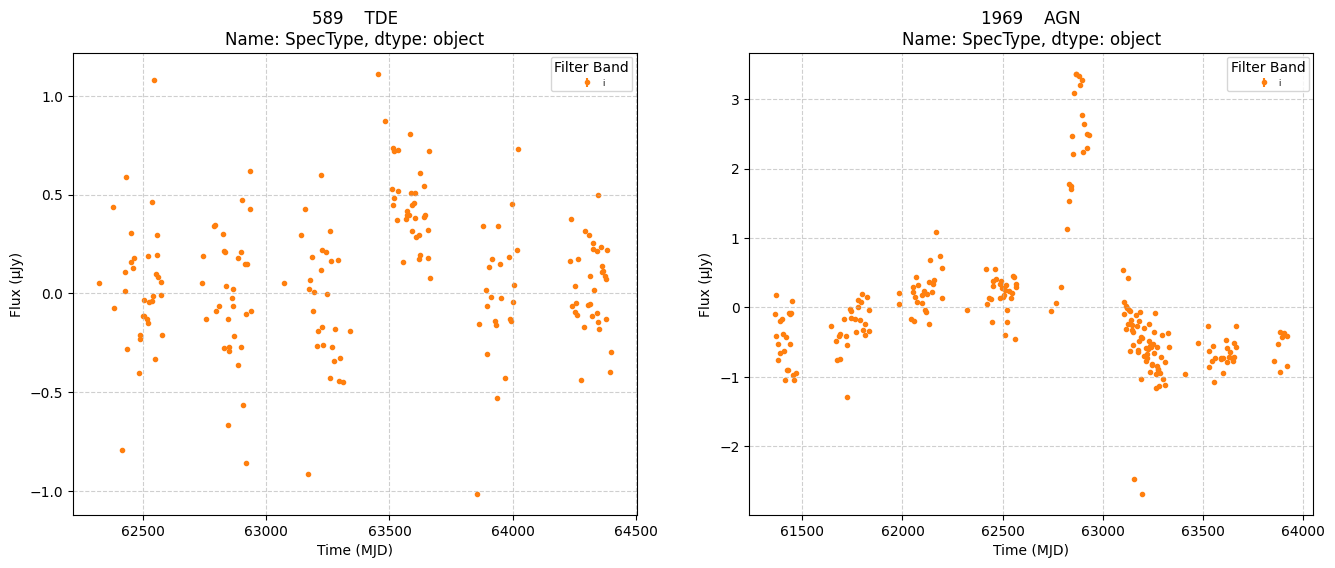

In [7]:
filters_list = ['i']

# Định nghĩa bố cục (1 hàng, 2 cột)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

i = 0
for index in outlier_log.index :
    time_records_plot(
        ax=axes[i],
        df_log=pd.DataFrame(outlier_log.loc[index]).T,
        filters_list=filters_list,
        show_error=0
    )
    i += 1

# index = outlier_log.index[0]
# for f in ['u', 'g', 'r', 'i', 'z', 'y'] :
#     time_distribution_plot(
#         ax=axes[i],
#         df_log=pd.DataFrame(outlier_log.loc[index]).T,
#         filters_list=[f]
#     )
#     i += 1

outlier_log


#### 2.2.1.1. <a id='toc2_2_1_1_'></a>[** Nhận xét:](#toc0_)

- Mặc dù số lượng bản ghi lớn hơn (~200 bản ghi), dữ liệu thực hiện quan sát không thường xuyên hơn, mà vẫn tỏ ra phân cụm. Tức có những thời điểm nhất định, các bản ghi được cập nhật nhiều hơn, và tiếp sau đó là một pha nghỉ khá dài. 

- Dự đoán là ta có thể phân chia được cụm thời gian này bằng thống kê cơ bản (ví dụ bằng Time (MJD)--standard)

### 2.2.2. <a id='toc2_2_2_'></a>[Biểu đồ phân phối time_diff](#toc0_)

,object_id,Z,Z_err,EBV,SpecType,split,target
589,salab_tirith_Ithil,0.2083,0.0,0.006,TDE,split_04,1
1969,ungol_aeruil_heledh,0.7428,0.0,0.009,AGN,split_13,0


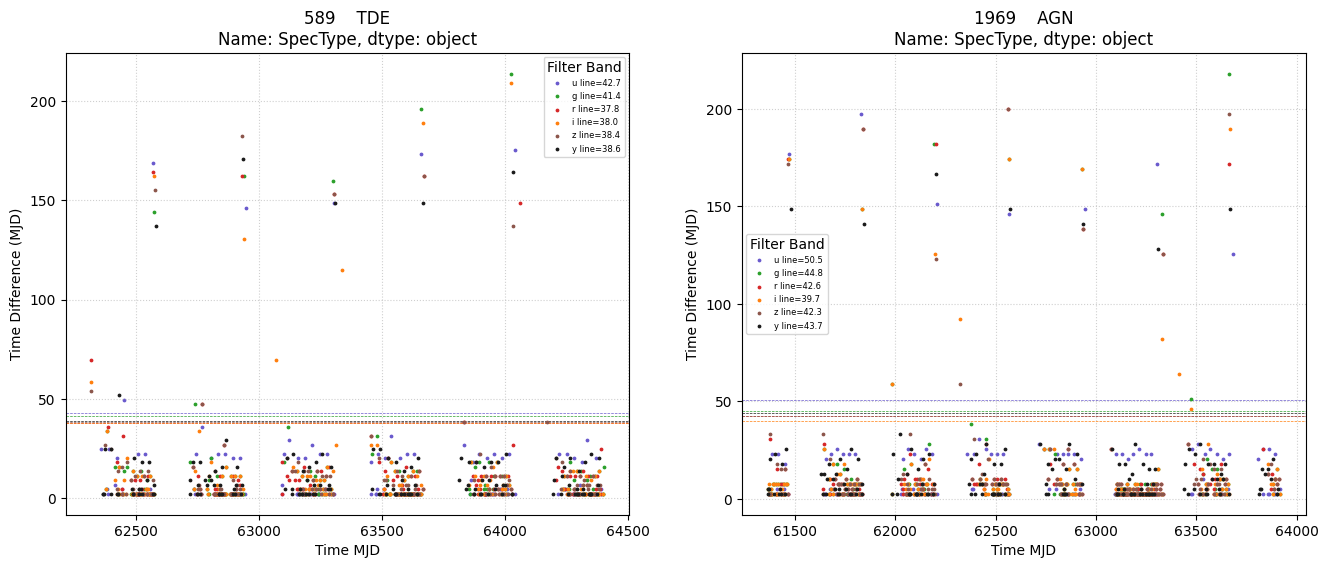

In [8]:
filters_list = ['u', 'g', 'r', 'i', 'z', 'y']

# Định nghĩa bố cục (1 hàng, 2 cột)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

i = 0
for index in outlier_log.index :
    time_distribution_plot(
        ax=axes[i],
        df_log=pd.DataFrame(outlier_log.loc[index]).T,
        filters_list=filters_list
    )
    i += 1

# index = outlier_log.index[0]
# for f in ['u', 'g', 'r', 'i', 'z', 'y'] :
#     time_distribution_plot(
#         ax=axes[i],
#         df_log=pd.DataFrame(outlier_log.loc[index]).T,
#         filters_list=[f]
#     )

outlier_log

#### 2.2.2.1. <a id='toc2_2_2_1_'></a>[** Nhận xét:](#toc0_)

- Như biểu đồ cũng cho thấy, các quãng nghỉ trong quá trình đo đạc diễn ra rất rõ ràng, outlier mạnh. Việc lấy separation line với y = standard(time_diff) đã là khá tốt, mặc dù cũng chưa quá tốt như kỳ vọng. 
    - Các biện pháp thay thế như mean, hay 3-Sigma và IQR không hiệu quả bằng. 
    - Trong khi standard * k với k là hằng số khá khó để đánh giá tổng thể

- Giải pháp chữa cháy: ta đánh dấu các outlier làm point-break giữa các cluster, sau đó sẽ vote cho các điểm này được join vào cluster gần nhất. 
    => Nó giúp giải quyết việc 2 point-break là 2 lần đo liên tiếp nhau (hoặc đơn giản là drop cái điểm ngoại lệ đi :v)

- Các lưu ý khác:
    - Các cluster nhỏ (1-2 records) có thể cũng sẽ bị ghi nhận, dẫn tới hiệu suất không quá cao
    - Ta chưa biết liệu phương pháp này có hiệu quả với những object có ít bản ghi hơn không (cỡ 20-40 records)
    
- Theo mấy plot bên dưới, với số lượng bản ghi ít hơn, ta có thể chấp nhận mức <strong><i><u>std * 1.25</u></i></strong>. Hoặc lấy cứng <u><i><strong>75 ngày</strong></i></u> cũng không tệ. Ta có thể gặp nhau ở <u><i><strong>max(100, std * 1.25)</strong></i></u>


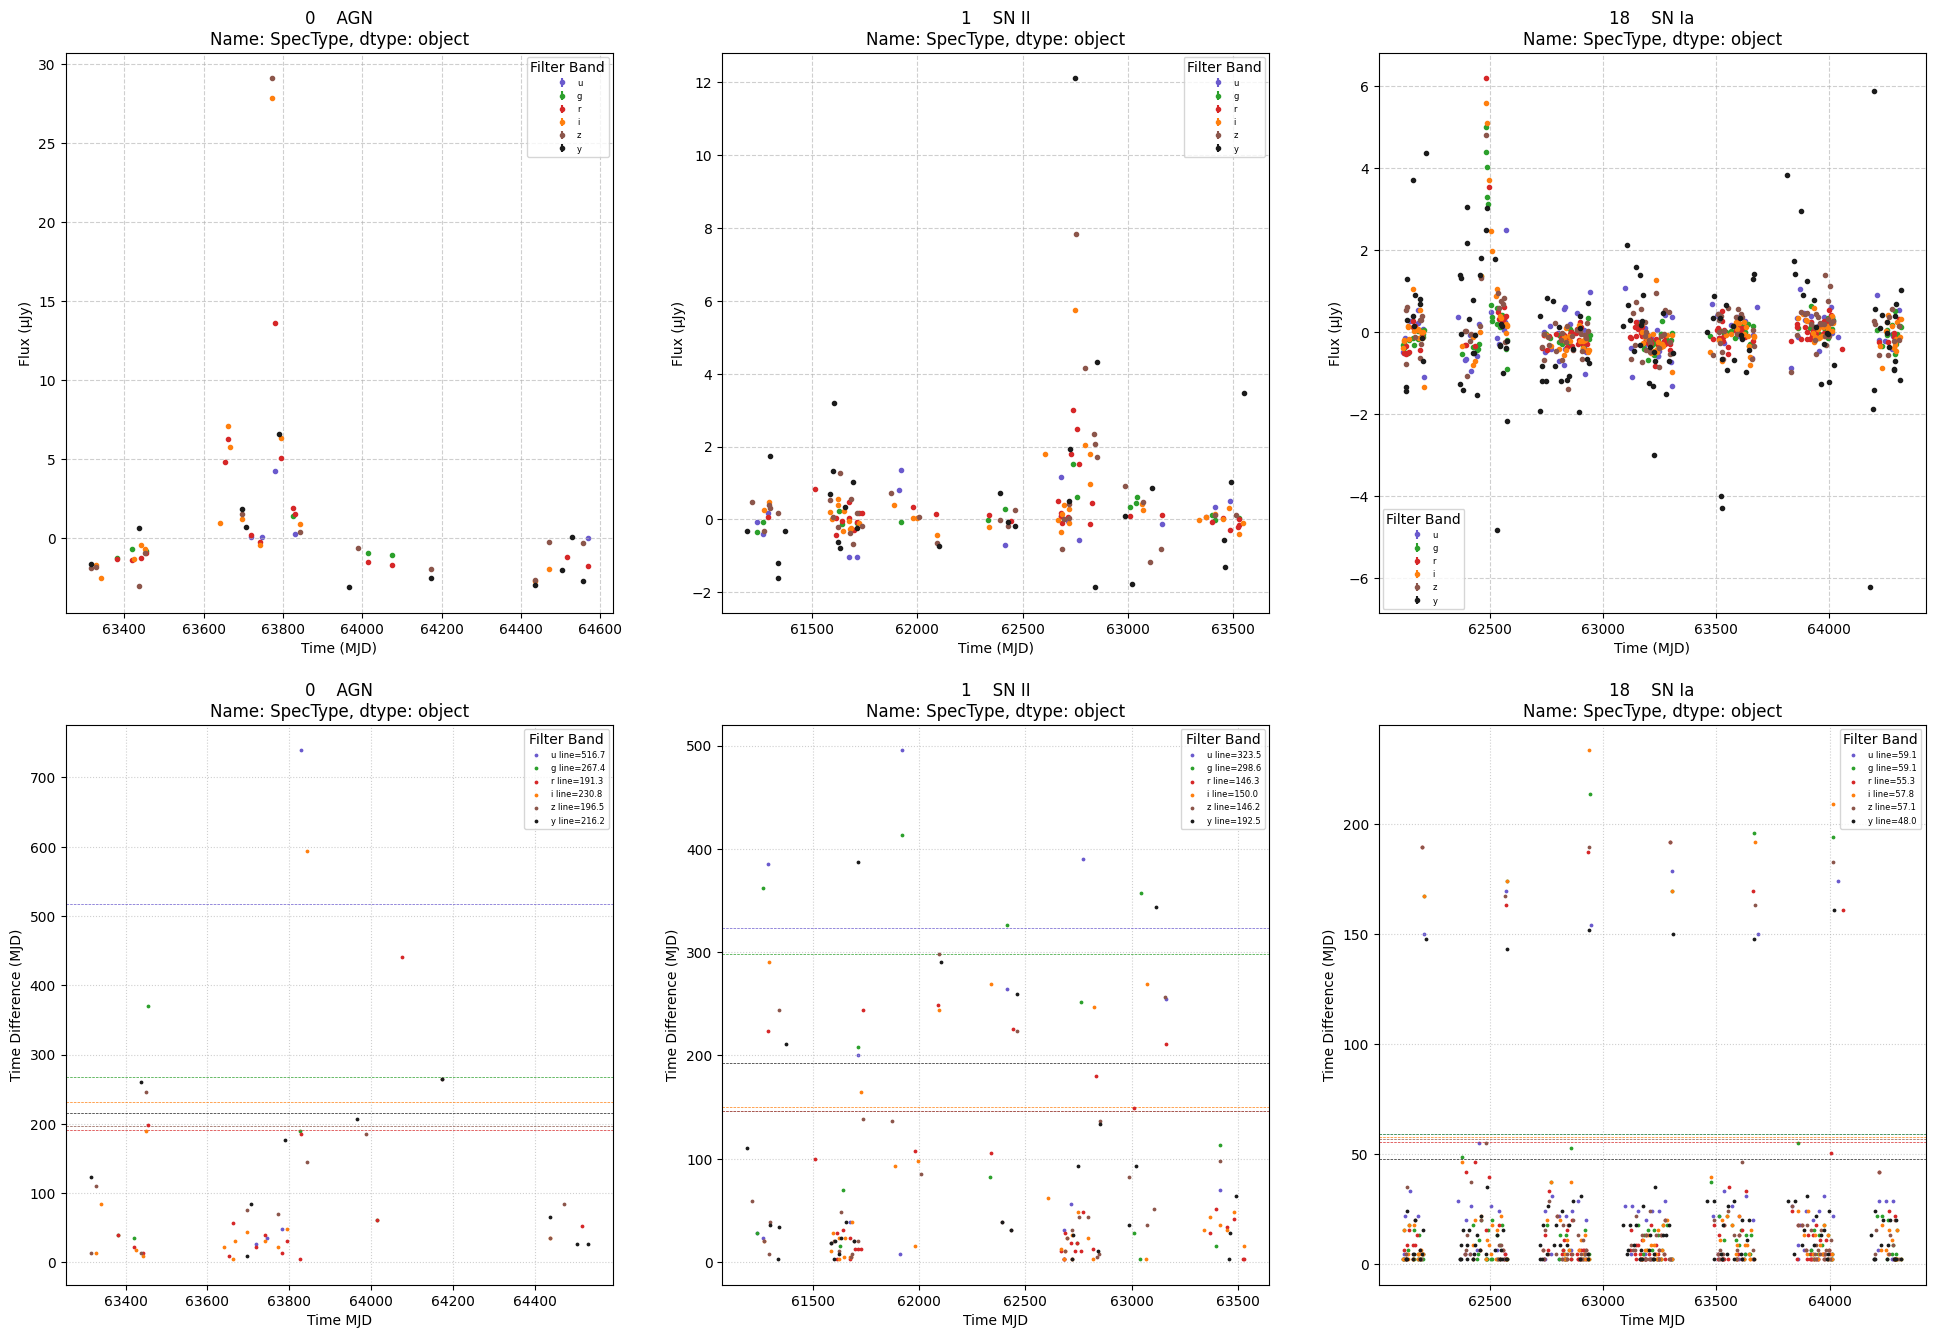

In [9]:
filters_list=['u', 'g', 'r', 'i', 'z', 'y']

# Định nghĩa bố cục (13 hàng, 2 cột)
fig, axes = plt.subplots(2, 3, figsize=(24, 8*2))

further_survey = train_log[train_log['object_id'].isin([
    'Dornhoth_fervain_onodrim',
    'Dornhoth_galadh_ylf',
    'araf_hub_faun',
])]

i = 0
for index in further_survey.index :
    time_records_plot(
        ax=axes[0][i],
        df_log=pd.DataFrame(further_survey.loc[index]).T,
        filters_list=filters_list,
        show_error=0
    )

    time_distribution_plot(
        ax=axes[1][i],
        df_log=pd.DataFrame(further_survey.loc[index]).T,
        filters_list=filters_list,
    )
    i += 1
    

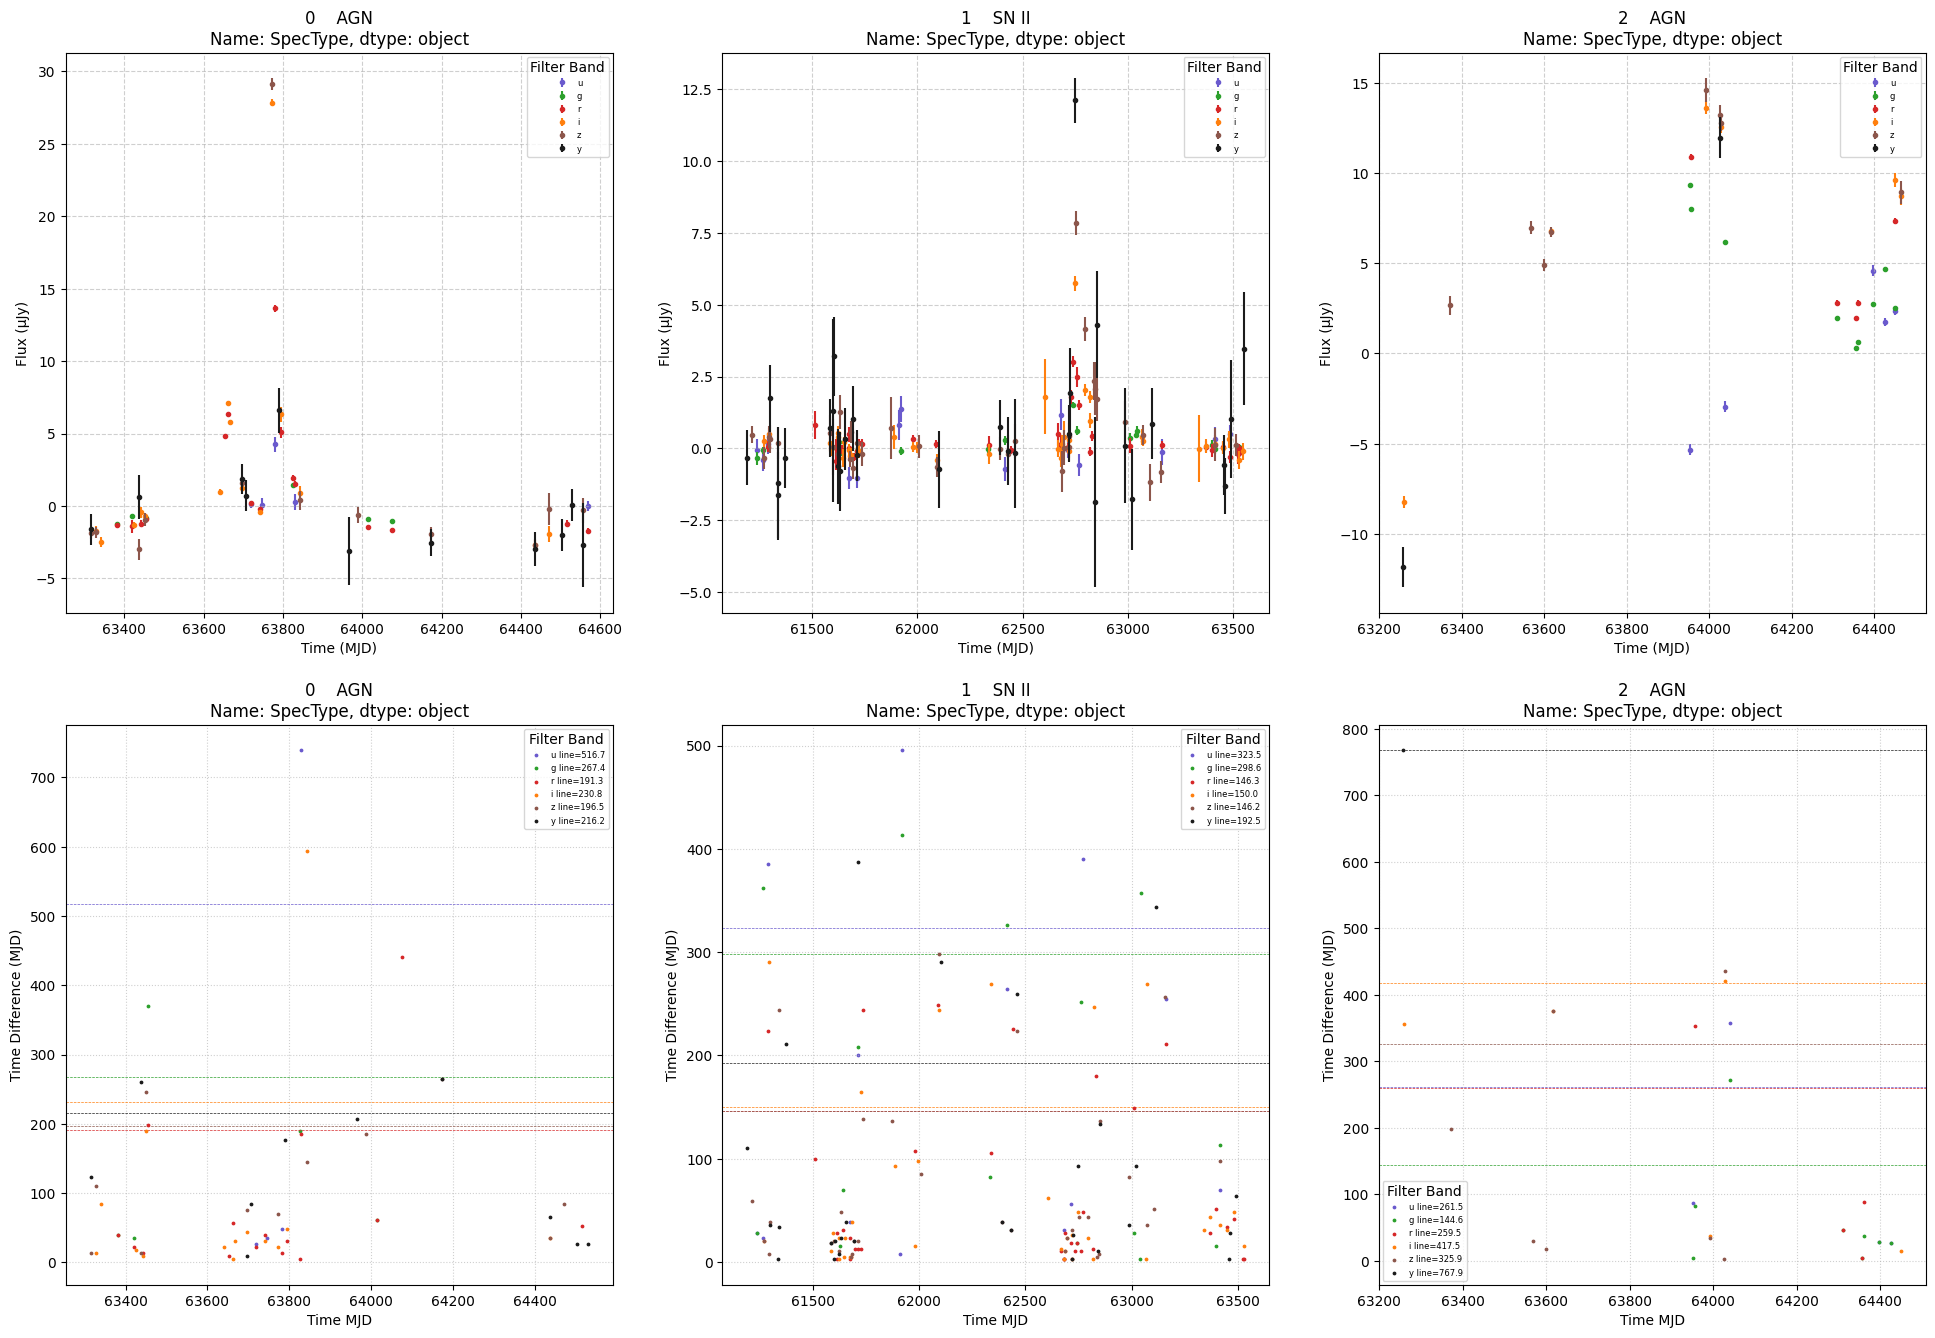

In [10]:
filters_list=['u', 'g', 'r', 'i', 'z', 'y']

# Định nghĩa bố cục (13 hàng, 2 cột)
fig, axes = plt.subplots(2, 3, figsize=(24, 8*2))

further_survey = train_log.head(3)

i = 0
for index in further_survey.index :
    time_records_plot(
        ax=axes[0][i],
        df_log=pd.DataFrame(further_survey.loc[index]).T,
        filters_list=filters_list,
        show_error=1
    )

    time_distribution_plot(
        ax=axes[1][i],
        df_log=pd.DataFrame(further_survey.loc[index]).T,
        filters_list=filters_list,
    )
    i += 1
    

# 3. Khảo sát test_log

In [11]:
test_log = pd.read_csv(path.join(dirname['root'], 'test_log.csv')).fillna('Unknown')
test_log.head(5)

,object_id,Z,Z_err,EBV,SpecType,English Translation,split
0,Eluwaith_Mithrim_nothrim,0.5393,0.03013,0.610,Unknown,Sindar + Sindar + family,split_01
1,Eru_heledir_archam,0.7282,0.03508,0.058,Unknown,God + kingfisher (bird) + throne,split_01
2,Gonhir_anann_fuin,0.6026,0.03185,0.070,Unknown,"Master of Stone, Dwarf + long, for a long tim...",split_01
3,Gwathuirim_haradrim_tegilbor,0.5298,0.03013,0.014,Unknown,Shadowy People (of Dunland) + People of the S...,split_01
4,achas_minai_maen,0.1654,0.02304,0.027,Unknown,"achas + distinct, unique, single + clever, sk...",split_01


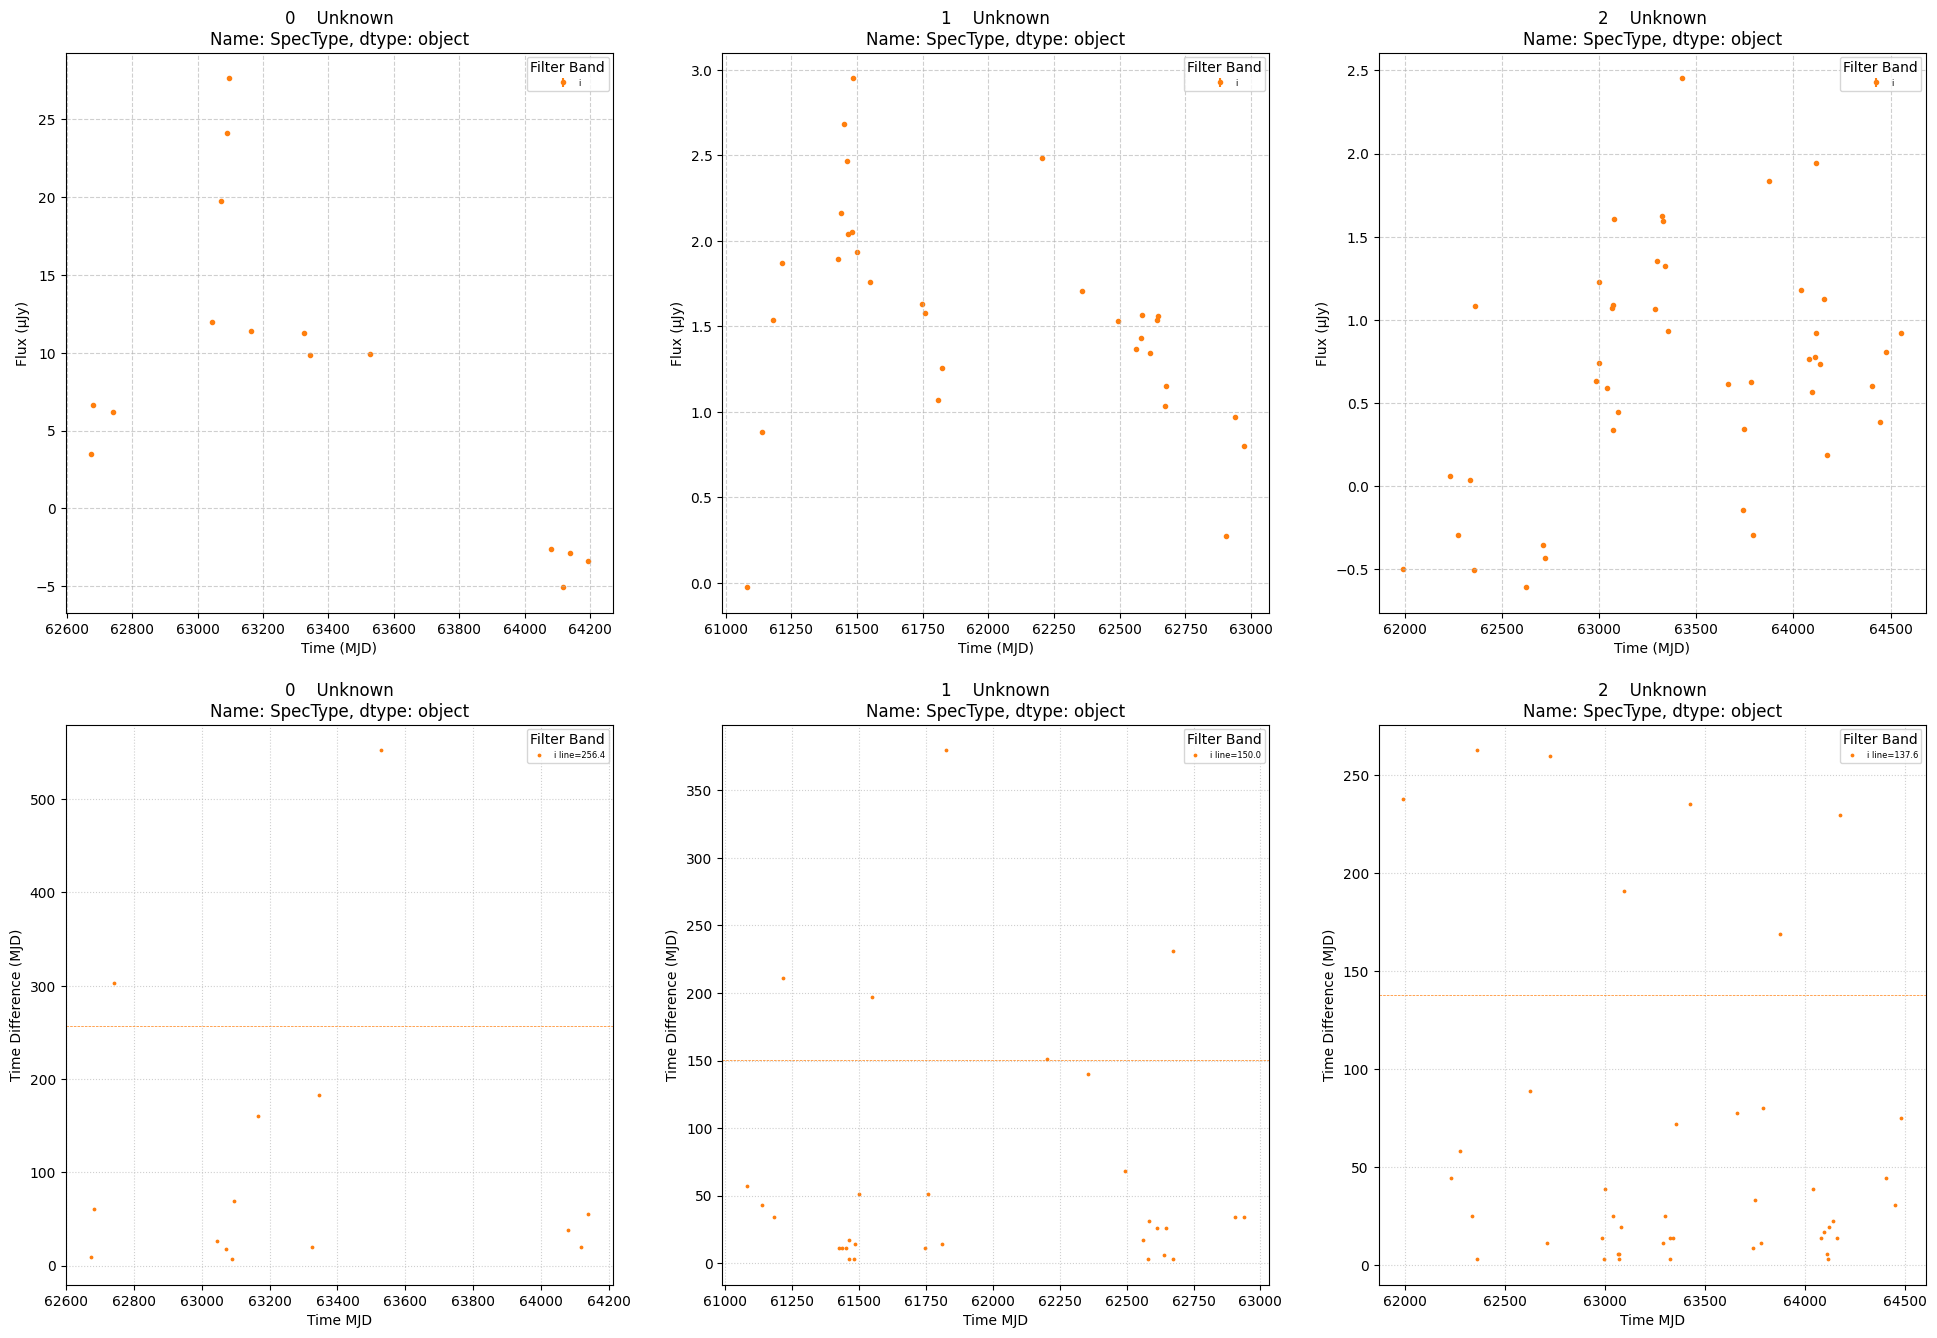

In [12]:
filters_list=['i']

# Định nghĩa bố cục (2 hàng, 3 cột)
fig, axes = plt.subplots(2, 3, figsize=(24, 8*2))

i = 0
for index in test_log.head(3).index :
    time_records_plot(
        ax=axes[0][i],
        df_log=pd.DataFrame(test_log.loc[index]).T,
        set='test',
        filters_list=filters_list,
        show_error=0
    )

    time_distribution_plot(
        ax=axes[1][i],
        df_log=pd.DataFrame(test_log.loc[index]).T,
        set='test',
        filters_list=filters_list,
    )
    i += 1

    

# 4. Tổng kết

- Việc chia cluster lại các split bằng đường chuẩn (cụ thể là standard * 1.25) có vẻ khả thi.
    - Biện pháp bổ sung: cần minimum_population cho cluster và tiến hành hợp nhất thiểu số

- Test_log có vẻ nhiễu mạnh hơn so với Train_log. Hoặc do chưa khảo sát kỹ